In [3]:
#Se importan la librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
#import quandl
#import pandas_datareader.data as web
import datetime
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.core import datetools

#Lectura del archivo .csv para manipular la data
f = open('predict_stockAPPLE.csv','rU')
acciones = pd.read_csv(f , parse_dates = True, index_col = 0)  #analiza la columna 0 como fechas
acciones.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
1980-12-12,28.75,28.87,28.75,28.75,2093900.0,0.0,1.0,0.416415,0.418153,0.416415,0.416415,117258400.0
1980-12-15,27.38,27.38,27.25,27.25,785200.0,0.0,1.0,0.396572,0.396572,0.394689,0.394689,43971200.0
1980-12-16,25.37,25.37,25.25,25.25,472000.0,0.0,1.0,0.367459,0.367459,0.365721,0.365721,26432000.0
1980-12-17,25.87,26.00,25.87,25.87,385900.0,0.0,1.0,0.374701,0.376584,0.374701,0.374701,21610400.0
1980-12-18,26.63,26.75,26.63,26.63,327900.0,0.0,1.0,0.385709,0.387447,0.385709,0.385709,18362400.0


In [4]:
acciones.index.sort_values()

DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-26',
               ...
               '2018-09-10', '2018-09-11', '2018-09-12', '2018-09-13',
               '2018-09-14', '2018-09-17', '2018-09-18', '2018-09-19',
               '2018-09-20', '2018-09-21'],
              dtype='datetime64[ns]', name=u'Date', length=9526, freq=None)

In [5]:
# Convert index to pandas datetime
acciones.index = pd.to_datetime(acciones.index, format="%Y/%m/%d")

In [8]:
acciones_final = acciones.drop(['Open','High','Low','Volume'], axis=1)

In [9]:
# Conver to Series to run Dickey-Fuller test
acciones_final = pd.Series(acciones_final['Close'])

In [11]:
type(acciones_final)

pandas.core.series.Series

In [12]:
def check_stationarity(ts_data):
    
    # Rolling statistics
    roll_mean = ts_data.rolling(30).mean()
    roll_std = ts_data.rolling(5).std()
    
    # Plot rolling statistics
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    acciones_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(acciones_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in acciones_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

Dickey-Fuller test results

Test Statistic      -2.109991
p-value              0.240516
# of lags           32.000000
# of obs          9493.000000
dtype: float64
Critical value at 5%: -2.86184
Critical value at 1%: -3.43104
Critical value at 10%: -2.56693


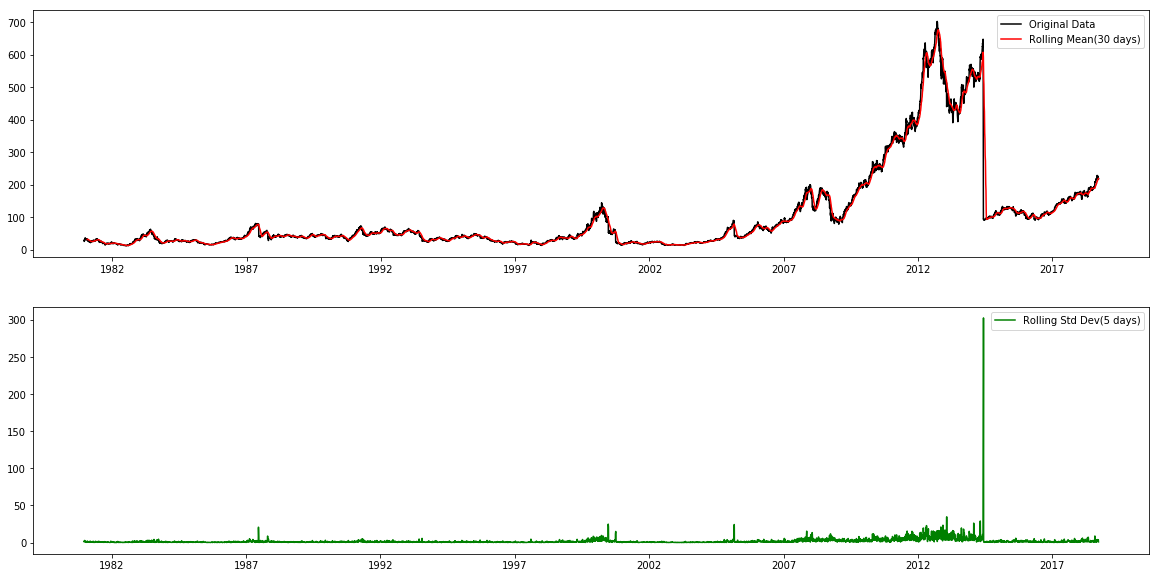

In [14]:
check_stationarity(acciones_final)

In [15]:
#Como la estadística de prueba es mayor que todos los valores críticos, 
#la serie de tiempo claramente no es estacionaria. 
#Se requieren pruebas de transformaciones diferentes para la estacionariedad antes de aplicar el modelo ARIMAa series de tiempo.
# Log transform time series
acciones_final_log = np.log(acciones_final)
acciones_final_log.head()

Date
1980-12-12    3.358638
1980-12-15    3.305054
1980-12-16    3.228826
1980-12-17    3.253084
1980-12-18    3.282038
Name: Close, dtype: float64

Dickey-Fuller test results

Test Statistic      -1.687954
p-value              0.437329
# of lags            4.000000
# of obs          9521.000000
dtype: float64
Critical value at 5%: -2.86184
Critical value at 1%: -3.43104
Critical value at 10%: -2.56693


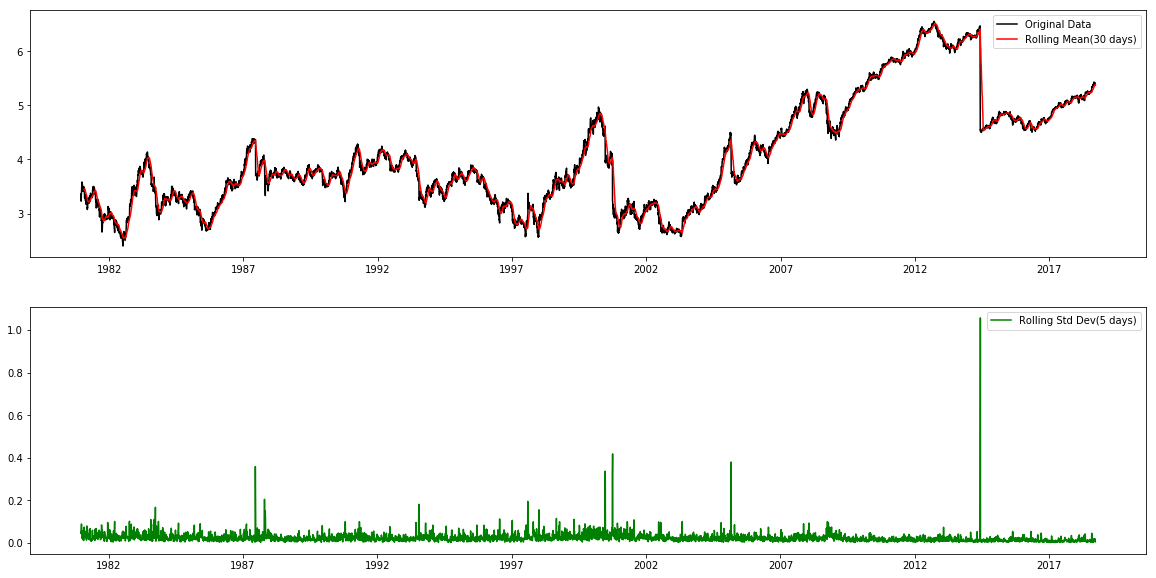

In [16]:
# Check stationarity
acciones_final_log.dropna(inplace=True)
check_stationarity(acciones_final_log)

In [ ]:
#La transformación de registro no es estacionaria ya que la estadística de prueba es mayor que los valores críticos 
#y también puede visualizar esto en el primer gráfico


In [17]:
#Log diferenciando transformación de series de tiempo originales
# Log Differencing
acciones_final_log_diff = acciones_final_log - acciones_final_log.shift()

Dickey-Fuller test results

Test Statistic     -48.788396
p-value              0.000000
# of lags            3.000000
# of obs          9521.000000
dtype: float64
Critical value at 5%: -2.86184
Critical value at 1%: -3.43104
Critical value at 10%: -2.56693


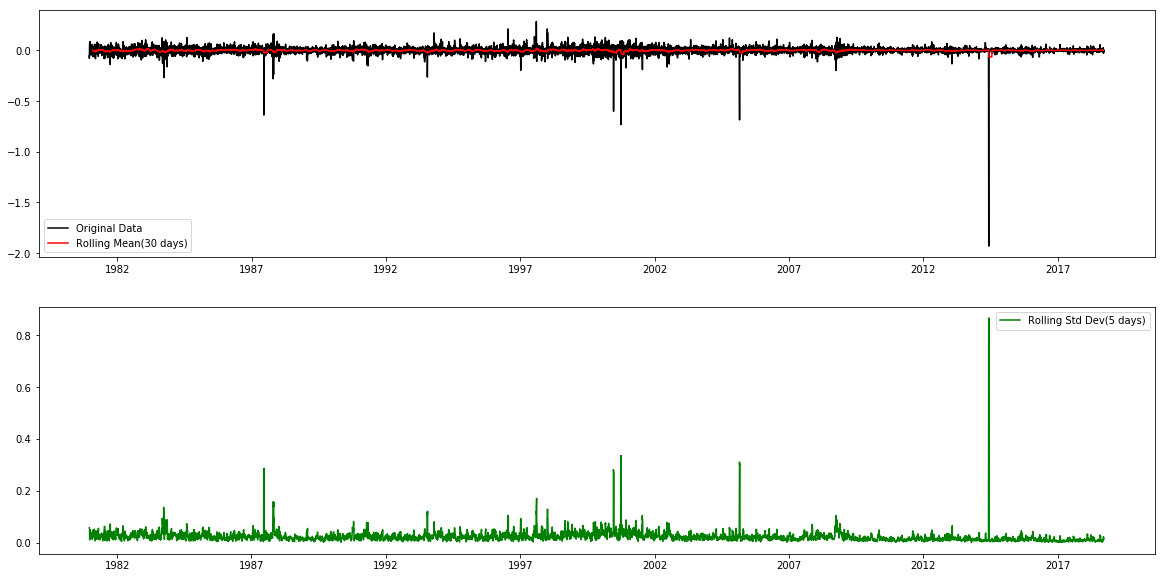

In [18]:
acciones_final_log_diff.dropna(inplace=True)
check_stationarity(acciones_final_log_diff)

In [19]:
#Transformación de diferenciación simple de series de tiempo originales
# Differencing
acciones_final_diff = acciones_final - acciones_final.shift()

Dickey-Fuller test results

Test Statistic   -1.815504e+01
p-value           2.470007e-30
# of lags         3.100000e+01
# of obs          9.493000e+03
dtype: float64
Critical value at 5%: -2.86184
Critical value at 1%: -3.43104
Critical value at 10%: -2.56693


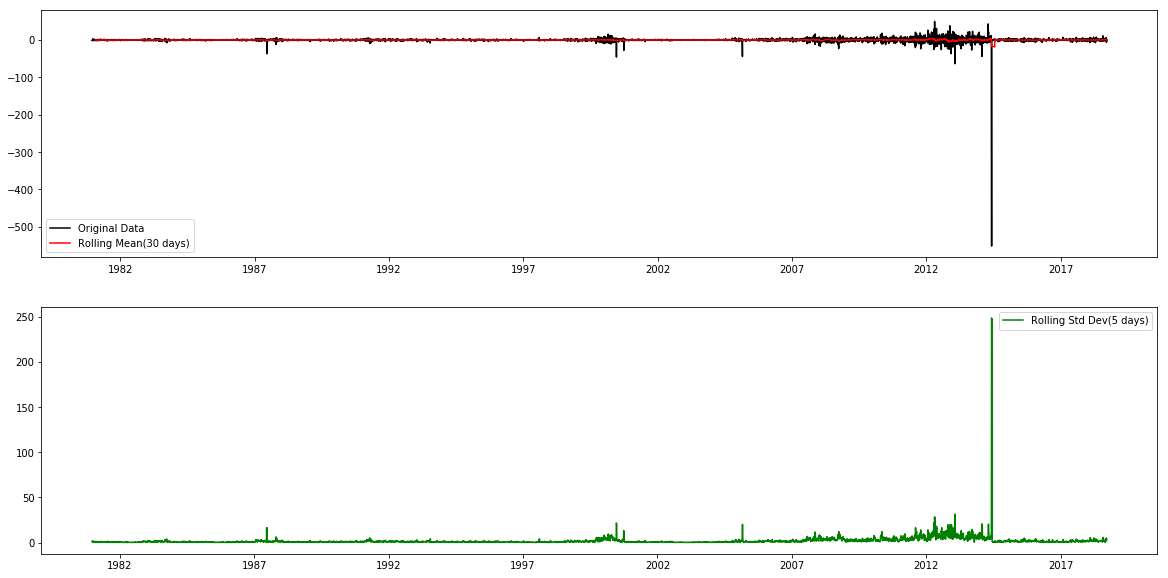

In [20]:
acciones_final_diff.dropna(inplace=True)
check_stationarity(acciones_final_diff)

In [21]:
#Como la diferenciación simple produce una estadística de prueba mucho más baja que los valores críticos, 
#la utilizaremos para aplicar ARIMA
from statsmodels.tsa.stattools import acf, pacf

In [22]:
acciones_acf = acf(acciones_final_diff)

In [23]:
acciones_pacf = pacf(acciones_final_diff)

In [24]:
import statsmodels.api as sm

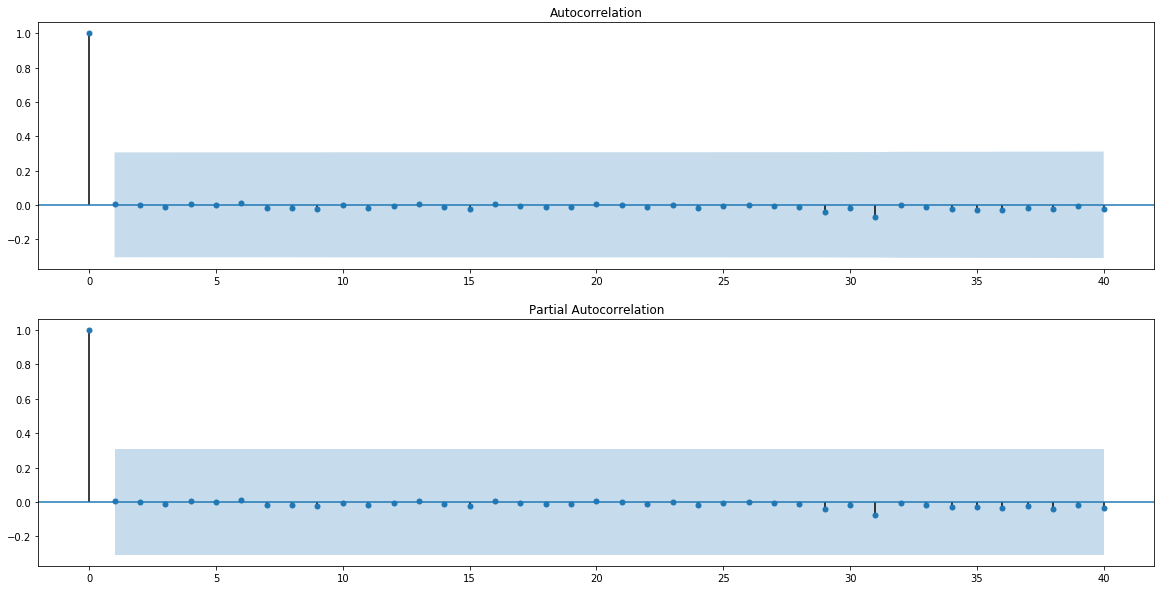

In [25]:
fig1 = plt.figure(figsize=(20,10))
ax1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(acciones_acf, ax=ax1)
ax2 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(acciones_pacf, ax=ax2)

In [26]:
model = ARIMA(acciones_final_diff, (1,1,0))

In [27]:
fit_model = model.fit(full_output=True)

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [28]:
predictions = model.predict(fit_model.params, start=1760, end=1769)

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [29]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 9524
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -33305.856
Method:                       css-mle   S.D. of innovations              7.989
Date:                Tue, 25 Sep 2018   AIC                          66617.712
Time:                        23:57:05   BIC                          66639.197
Sample:                    12-16-1980   HQIC                         66625.002
                         - 09-21-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.602e-05      0.055      0.001      0.999      -0.107       0.107
ar.L1.D.Close    -0.4946      0.009    -55.541      0.000      -0.512      -0.477
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0219           +0.0000j            2.0219            0.5000
-----------------------------------------------------------------------------
"""

In [30]:
predictions

array([-1.11272389,  0.49468648,  0.61833343, -1.11272389, -0.98907694,
        0.37103953,  0.49468648,  0.37103953,  0.24739257, -1.97825255])

In [31]:
fit_model.predict(start=1760, end=1769)

Date
1987-12-02   -1.112724
1987-12-03    0.494686
1987-12-04    0.618333
1987-12-07   -1.112724
1987-12-08   -0.989077
1987-12-09    0.371040
1987-12-10    0.494686
1987-12-11    0.371040
1987-12-14    0.247393
1987-12-15   -1.978253
dtype: float64

In [32]:
#Es hora de volver a transformar los datos a la escala original
pred_model_diff = pd.Series(fit_model.fittedvalues, copy=True)
pred_model_diff.head()

Date
1980-12-16    0.000066
1980-12-17    0.247393
1980-12-18   -1.295721
1980-12-19   -0.069144
1980-12-22   -0.425247
dtype: float64

In [33]:
# Calculate cummulative sum of the fitted values (cummulative sum of differences)
pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

Date
1980-12-16    0.000066
1980-12-17    0.247459
1980-12-18   -1.048263
1980-12-19   -1.117406
1980-12-22   -1.542653
dtype: float64

In [34]:
# Element-wise addition back to original time series
acciones_final_trans = acciones_final.add(pred_model_diff_cumsum, fill_value=0)
# Last 5 rows of fitted values
acciones_final_trans.tail()

Date
2018-09-17    219.348522
2018-09-18    221.385273
2018-09-19    218.389577
2018-09-20    220.163431
2018-09-21    217.036810
dtype: float64

In [35]:
# Last 5 rows of original time series
acciones_final.tail()

Date
2018-09-17    217.88
2018-09-18    218.24
2018-09-19    218.37
2018-09-20    220.03
2018-09-21    217.66
Name: Close, dtype: float64

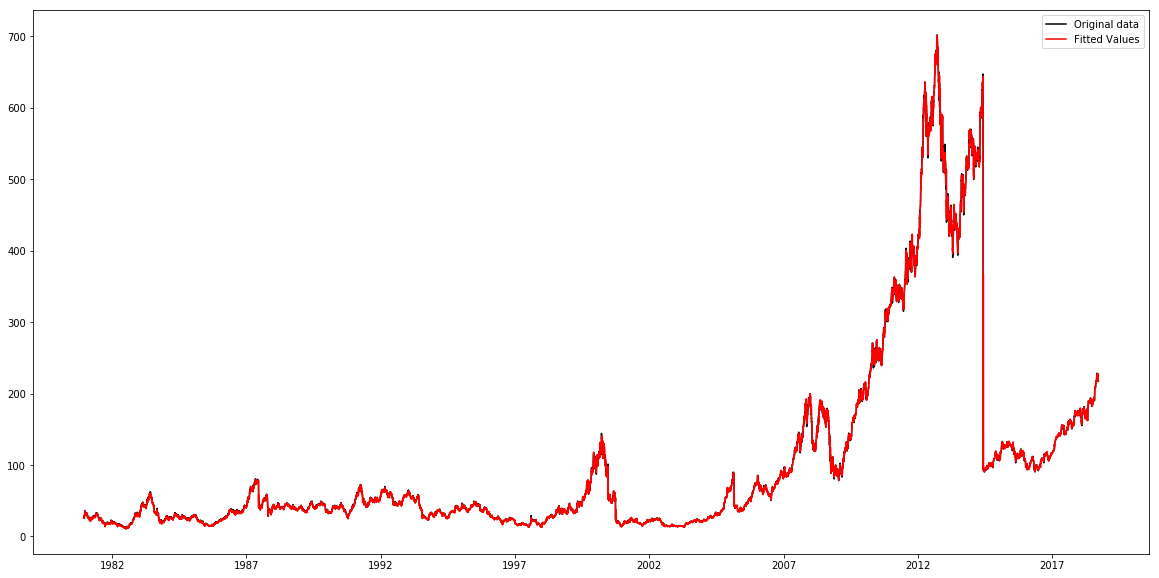

In [36]:
# Plot of orignal data and fitted values
plt.figure(figsize=(20,10))
plt.plot(acciones_final, color='black', label='Original data')
plt.plot(acciones_final_trans, color='red', label='Fitted Values')
plt.legend()

In [37]:
x = acciones_final.values
y = acciones_final_trans.values

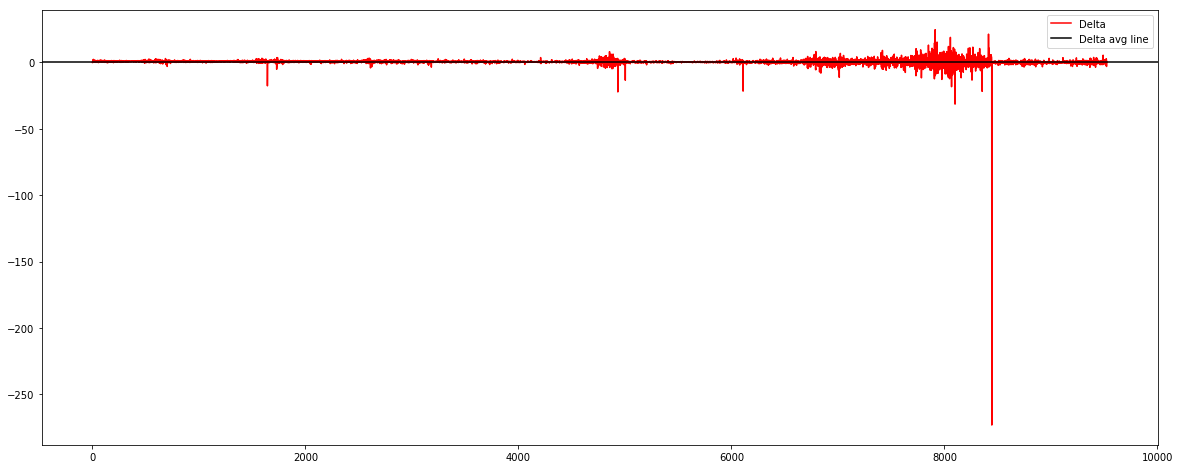

In [38]:
# Trend of error
plt.figure(figsize=(20,8))
plt.plot((x - y), color='red', label='Delta')
plt.axhline((x-y).mean(), color='black', label='Delta avg line')
plt.legend()

In [ ]:
#El error promedio parece ser de alrededor de $ 0.35 por acción

In [39]:
#El último paso es crear una serie con diez valores de predicción
final_pred = []
for i in predictions:
    t = acciones_final[-1] + i
    final_pred.append(t)

In [40]:
final_pred = pd.Series(final_pred)
final_pred

0    216.547276
1    218.154686
2    218.278333
3    216.547276
4    216.670923
5    218.031040
6    218.154686
7    218.031040
8    217.907393
9    215.681747
dtype: float64